# Detecting Twitter Bots 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer,accuracy_score,precision_score,recall_score,f1_score


In [2]:
file = "C:\\Users\\PRIYANKA\\AppData\\Local\\Programs\\Python\\Python39\\Scripts\\EDI\\training_data_2_csv_UTF.csv"


training_data = pd.read_csv(file)
bots = training_data[training_data.bot==1]
nonbots = training_data[training_data.bot==0]


# Data Analysis

# <h2> Identifying Missing data</h2>


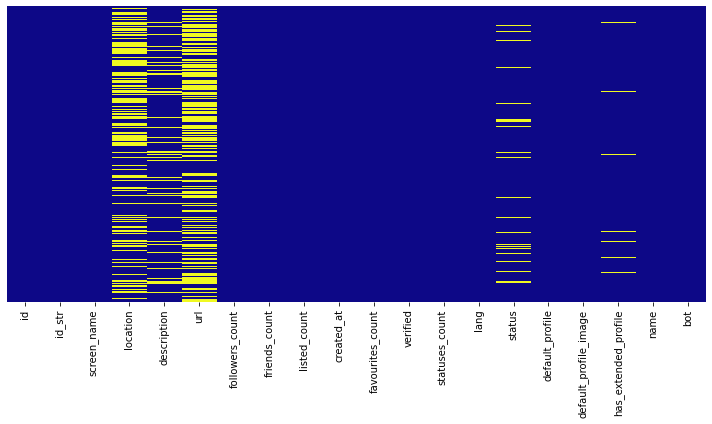

In [3]:
def get_heatmap(df):
    #This function gives heatmap of all NaN values
    plt.figure(figsize=(10,6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='plasma')
    plt.tight_layout()
    return plt.show()

get_heatmap(training_data)


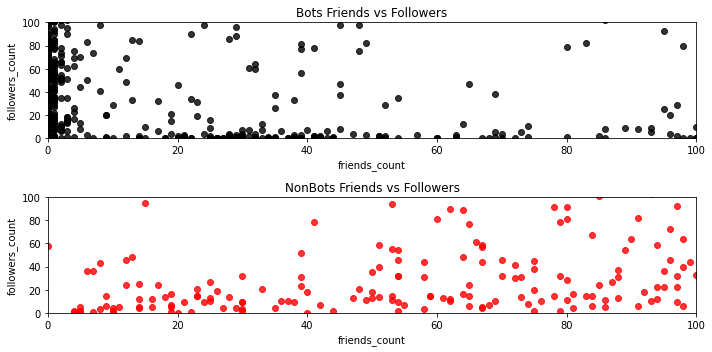

In [4]:
bots.friends_count/bots.followers_count

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Bots Friends vs Followers')
sns.regplot(bots.friends_count, bots.followers_count, color='black', label='Bots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

plt.subplot(2,1,2)
plt.title('NonBots Friends vs Followers')
sns.regplot(nonbots.friends_count, nonbots.followers_count, color='red', label='NonBots')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()


# <h2> Identifying Imbalance in the data</h2> 

In [5]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

nonbots['friends_by_followers'] = nonbots.friends_count/nonbots.followers_count
nonbots[nonbots.friends_by_followers<1].shape

(952, 21)

(504, 21)


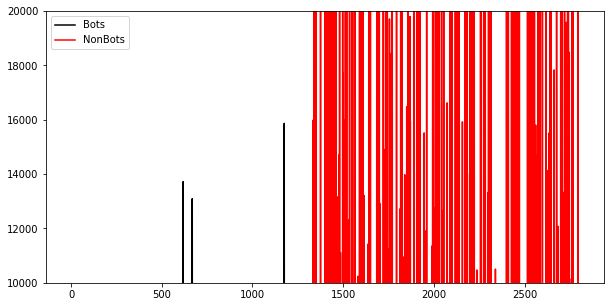

In [6]:
plt.figure(figsize=(10,5))
plt.plot(bots.listed_count, color='black', label='Bots')
plt.plot(nonbots.listed_count, color='red', label='NonBots')
plt.legend(loc='upper left')
plt.ylim(10000,20000)
print(bots[(bots.listed_count<5)].shape)

In [7]:
bots_listed_count_df = bots[bots.listed_count<16000]
nonbots_listed_count_df = nonbots[nonbots.listed_count<16000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape

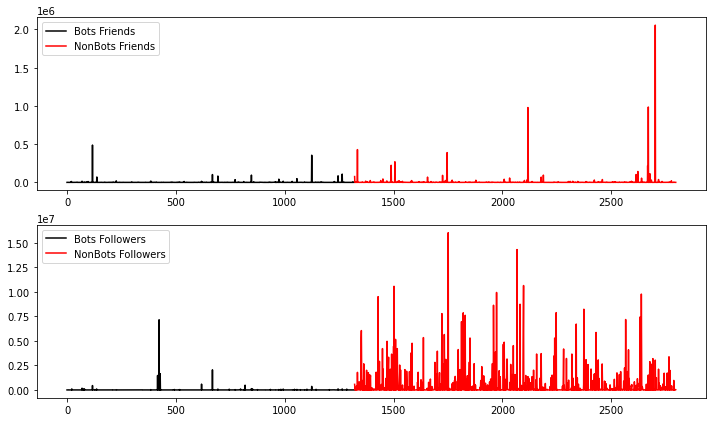

In [8]:
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(bots_listed_count_df.friends_count, color='black', label='Bots Friends')
plt.plot(nonbots_listed_count_df.friends_count, color='red', label='NonBots Friends')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(bots_listed_count_df.followers_count, color='black', label='Bots Followers')
plt.plot(nonbots_listed_count_df.followers_count, color='red', label='NonBots Followers')
plt.legend(loc='upper left')

In [9]:
#bots[bots.listedcount>10000]
condition = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.description.str.contains("bot", case=False)==True)|(bots.location.isnull())|(bots.verified==False)

bots['screen_name_binary'] = (bots.screen_name.str.contains("bot", case=False)==True)
bots['location_binary'] = (bots.location.isnull())
bots['verified_binary'] = (bots.verified==False)
bots.shape

(1321, 24)

In [10]:
condition = (nonbots.screen_name.str.contains("bot", case=False)==False)| (nonbots.description.str.contains("bot", case=False)==False) |(nonbots.location.isnull()==False)|(nonbots.verified==True)

nonbots['screen_name_binary'] = (nonbots.screen_name.str.contains("bot", case=False)==False)
nonbots['location_binary'] = (nonbots.location.isnull()==False)
nonbots['verified_binary'] = (nonbots.verified==True)

nonbots.shape

(1476, 24)

In [11]:
df = pd.concat([bots, nonbots])
df.shape

(2797, 24)

# Feature Independence using Spearman correlation

In [12]:
df.corr(method='spearman')

,id,followers_count,friends_count,listed_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,bot,friends_by_followers,screen_name_binary,location_binary,verified_binary
id,1.000000,-0.672925,-0.402346,-0.615005,-0.439430,-0.611899,-0.451945,0.522990,0.166601,0.652131,0.270435,-0.576100,-0.228328,0.150100
followers_count,-0.672925,1.000000,0.375522,0.896126,0.457363,0.709732,0.649117,-0.496899,-0.293838,-0.468430,-0.577157,0.458213,0.189675,0.130717
friends_count,-0.402346,0.375522,1.000000,0.204403,0.641529,0.356452,0.111118,-0.296358,-0.097607,-0.483105,0.427638,0.342145,0.082692,-0.210592
listed_count,-0.615005,0.896126,0.204403,1.000000,0.349059,0.694340,0.684976,-0.447376,-0.269035,-0.318445,-0.681034,0.338698,0.188797,0.281360
favourites_count,-0.439430,0.457363,0.641529,0.349059,1.000000,0.394227,0.295108,-0.348043,-0.226956,-0.526228,0.104797,0.408864,0.120941,-0.220894
verified,-0.611899,0.709732,0.356452,0.694340,0.394227,1.000000,0.333278,-0.404650,-0.132298,-0.508555,-0.419815,0.434177,0.191922,0.346505
statuses_count,-0.451945,0.649117,0.111118,0.684976,0.295108,0.333278,1.000000,-0.375918,-0.289999,-0.089018,-0.533971,0.162213,0.105333,0.207384
default_profile,0.522990,-0.496899,-0.296358,-0.447376,-0.348043,-0.404650,-0.375918,1.000000,0.246979,0.407748,0.197929,-0.377572,-0.138378,0.072351
default_profile_image,0.166601,-0.293838,-0.097607,-0.269035,-0.226956,-0.132298,-0.289999,0.246979,1.000000,0.139669,0.190986,-0.166388,0.000596,0.033021
bot,0.652131,-0.468430,-0.483105,-0.318445,-0.526228,-0.508555,-0.089018,0.407748,0.139669,1.000000,-0.044056,-0.843429,-0.266342,0.606771


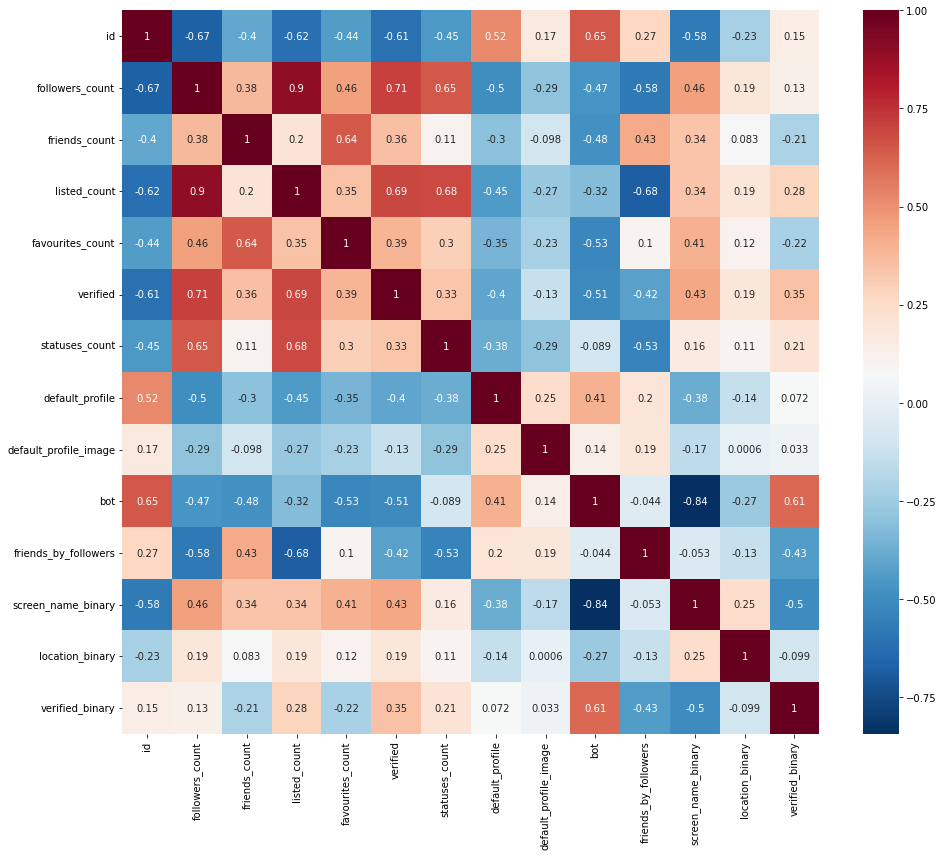

In [13]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(method='spearman'), cmap='RdBu_r', annot=True)
plt.tight_layout()
plt.show()

# <h2>Performing Feature Engineering</h2>

In [14]:
filepath = 'C:\\Users\\PRIYANKA\\AppData\\Local\\Programs\\Python\\Python39\\Scripts\\EDI\\training_data_2_csv_UTF.csv'
file= open(filepath, mode='r', encoding='utf-8', errors='ignore')

training_data = pd.read_csv(file)

bag_of_words_bot = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                    r'expos|kill|clit|bbb|butt|fuck|XXX|sex|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                    r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|xx|freak|ffd|dunia|clone|genie|bbb' \
                    r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'
            
training_data['screen_name_binary'] = training_data.screen_name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['name_binary'] = training_data.name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['description_binary'] = training_data.description.str.contains(bag_of_words_bot, case=False, na=False)
training_data['status_binary'] = training_data.status.str.contains(bag_of_words_bot, case=False, na=False)

<h2>Performing Feature Extraction</h2>

In [15]:
training_data['listed_count_binary'] = (training_data.listed_count>20000)==False
features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

# Implementing Classifiers


Decision Tree

In [16]:

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

dtAccuracy=accuracy_score(y_test, y_pred_test)
dtPrecision=precision_score(y_test, y_pred_test, average='binary')
dtF1_score=f1_score(y_test, y_pred_test, average='binary')
dtRecall=recall_score(y_test, y_pred_test, average='binary')


print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.88707
Test Accuracy: 0.87857


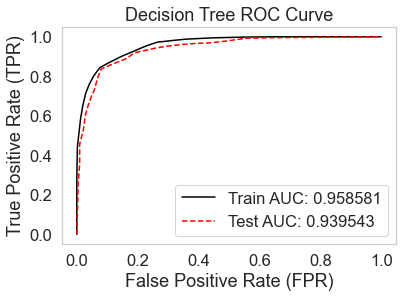

In [17]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = dt.predict_proba(X_train)
scores_test = dt.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_dt_train, tpr_dt_train, color='black', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

Multinomial Naive Bayes Classifier

In [18]:
X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

mnb = MultinomialNB(alpha=0.0009)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

mnb = mnb.fit(X_train, y_train)
y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)

mnbAccuracy=accuracy_score(y_test, y_pred_test)
mnbPrecision=precision_score(y_test, y_pred_test, average='binary')
mnbF1_score=f1_score(y_test, y_pred_test, average='binary')
mnbRecall=recall_score(y_test, y_pred_test, average='binary')

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.67961
Test Accuracy: 0.69762


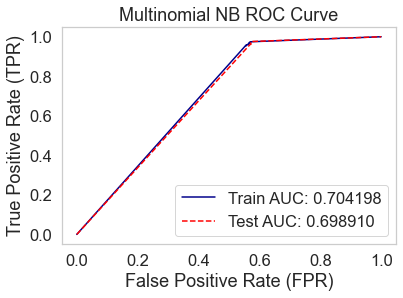

In [19]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = mnb.predict_proba(X_train)
scores_test = mnb.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_mnb_train, tpr_mnb_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_mnb_test, tpr_mnb_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_mnb_train, tpr_mnb_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_mnb_train, tpr_mnb_train))
plt.plot(fpr_mnb_test, tpr_mnb_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_mnb_test, tpr_mnb_test))
plt.title("Multinomial NB ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

Random Forest

In [20]:

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

rfAccuracy=accuracy_score(y_test, y_pred_test)
rfPrecision=precision_score(y_test, y_pred_test, average='binary')
rfF1_score=f1_score(y_test, y_pred_test, average='binary')
rfRecall=recall_score(y_test, y_pred_test, average='binary')


print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.87532
Test Accuracy: 0.86071


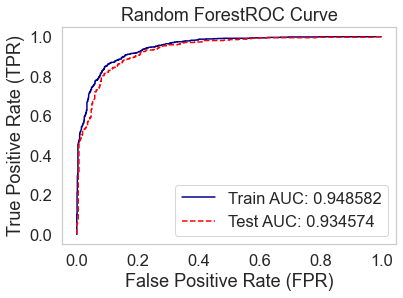

In [21]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rf.predict_proba(X_train)
scores_test = rf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("Random ForestROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

svm


In [22]:

svm = SVC(gamma='auto',probability=True)
svm.fit(X_train, y_train)
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

svmAccuracy=accuracy_score(y_test, y_pred_test)
svmPrecision=precision_score(y_test, y_pred_test, average='binary')
svmF1_score=f1_score(y_test, y_pred_test, average='binary')
svmRecall=recall_score(y_test, y_pred_test, average='binary')

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))



Trainig Accuracy: 0.99642
Test Accuracy: 0.53690


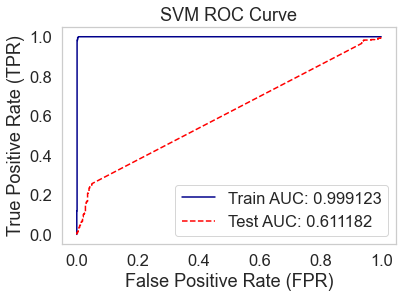

In [23]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = svm.predict_proba(X_train)
scores_test = svm.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_svm_train, tpr_svm_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_svm_test, tpr_svm_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_svm_train, tpr_svm_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_svm_train, tpr_svm_train))
plt.plot(fpr_svm_test, tpr_svm_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_svm_test, tpr_svm_test))
plt.title("SVM ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

# Performance Evaluation

In [24]:
models_scores_table = pd.DataFrame({'Decision Tree Classifier':[dtAccuracy,dtPrecision,dtF1_score,dtRecall],
                                       
                                      'Random Forest Classifier':[rfAccuracy,rfPrecision,rfF1_score,rfRecall],
                                       
                                      
                        
                                      'Multinomial Naive Bayes':[mnbAccuracy,mnbPrecision,mnbF1_score,mnbRecall],
                                        
                                      
                                       
                                      'Support Vector Machine':[svmAccuracy,svmPrecision,svmF1_score,svmRecall]},
                                       
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)

table=models_scores_table.style.set_properties(**{'background-color': 'pink', 'color':'black', 'border':'1.3px solid black'}).set_caption("RESULTS") 
headers={'selector':'th:not(.index_name)','props':'color: darkblue;'}
table.set_table_styles([headers])
table

,Decision Tree Classifier,Random Forest Classifier,Multinomial Naive Bayes,Support Vector Machine,Best Score
Accuracy,0.878571,0.860714,0.697619,0.536905,Decision Tree Classifier
Precision,0.911227,0.890625,0.625966,0.804348,Decision Tree Classifier
Recall,0.872500,0.853933,0.761278,0.159827,Decision Tree Classifier
F1 Score,0.836930,0.820144,0.971223,0.088729,Multinomial Naive Bayes
